Plots win rate of baseline attacks.

In [1]:
import pathlib
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.api import DescrStatsW
from statsmodels.stats.proportion import proportion_confint

from sgf_parser import game_info
import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("2-col")]
)

In [2]:
dfs = []
directory = pathlib.Path("/nas/ucb/ttseng/go_attack/baseline-attack/20221122-rescored")
for path in directory.iterdir():
    if path.suffix != ".sgfs":
        continue
    # path.stem has the format 
    # cpN[h]-vN-{bw}-vs-(attack).sgfs, e.g. cp505h-v16-b-vs-edge.sgfs
    features = path.stem.split("-")
    victim_name = features[0]
    num_visits = int(features[1][1:])
    victim_color = features[2]
    policy = features[-1]

    df = pd.DataFrame(
        game_info.read_and_parse_file(path, fast_parse=True, victim_color=victim_color)
    )
    df["victim_name"] = victim_name
    df["victim_visits"] = num_visits
    df["adv_name"] = policy
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df["adv_win"] = df["adv_color"] == df["win_color"]
print(len(df))

9600


In [3]:
results = df.groupby(["victim_name", "victim_color", "adv_name", "victim_visits"]).mean(
    numeric_only=True
)
print(results.adv_win)
print(results.adv_minus_victim_score)

victim_name  victim_color  adv_name  victim_visits
cp505        b             edge      1                0.49375
                                     2                0.51250
                                     4                0.53750
                                     8                0.51250
                                     16               0.34375
                                     32               0.13750
                           mirror    1                0.07500
                                     2                0.00000
                                     4                0.02500
                                     8                0.01250
                                     16               0.00625
                                     32               0.01875
                           spiral    1                0.04375
                                     2                0.03125
                                     4                0.03750
                   

In [4]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# Need to be consistent with colors across different plots.
policy_to_plot_color = {
    "edge": colors[0],
    "spiral": colors[1],
    "mirror": colors[2],
}


def generate_plots(df: pd.DataFrame, column: str, y_lower: int, y_upper: int) -> List[Dict[str, Any]]:
    """Generates plots of baseline attack win rate.
    
    Args:
        df: Baseline attack games.
        column: Which column of the df to plot on the y-axis.
        y_lower: Lower bound of y-axis.
        y_upper: Upper bound of y-axis.
        
    Returns:
        List of dicts, each dict containing a plot and information about the plot.
    """
    
    assert column in ["adv_win", "adv_minus_victim_score"]
    column_label = {"adv_win": "Win \%", "adv_minus_victim_score": "Win margin"}[column]
    y_multiplier = {
        "adv_win": 100,
        "adv_minus_victim_score": 1,
    }[column]

    plots = []
    for victim_name in sorted(df["victim_name"].unique()):
        victim_name_df = df.query(f"victim_name == '{victim_name}'")
        for victim_color in sorted(df["victim_color"].unique()):
            fig, ax = plt.subplots(1, 1)

            victim_df = victim_name_df.query(f"victim_color == '{victim_color}'")
            for adv_name in sorted(victim_df["adv_name"].unique()):
                color = policy_to_plot_color[adv_name]
                data = victim_df.query(f"adv_name == '{adv_name}'")
                grouped_data = data.groupby("victim_visits")[column]
                grouped_data_mean = grouped_data.mean(numeric_only=True)
                (y_multiplier * grouped_data_mean).plot(label=adv_name, color=color)

                # Plot confidence intervals.
                if column == "adv_win":
                    conf_df = grouped_data.apply(
                        lambda x: proportion_confint(
                            x.sum(),
                            len(x),
                            alpha=0.05,
                            # Generate Clopper-Pearson confidence intervals:
                            # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html
                            method="beta",
                        )
                    )
                elif column == "adv_minus_victim_score":
                    conf_df = grouped_data.apply(
                        lambda x: DescrStatsW(x).tconfint_mean()
                    )
                # conf_df is a Series of 2-tuples. Convert the tuples into separate columns.
                conf_df = conf_df.apply(pd.Series)
                plt.fill_between(
                    grouped_data_mean.index,
                    conf_df[0] * y_multiplier,
                    conf_df[1] * y_multiplier,
                    alpha=0.3,
                    color=color,
                )

            victim_label = "\\texttt{Latest}"
            if victim_name == "cp505h":
                victim_label += "_\\texttt{def}"
            plt.ylabel(f"{column_label} vs. ${victim_label}$ ({victim_color.upper()})", fontsize='small')
            plt.ylim(y_lower, y_upper)
            plt.xscale("log")
            plt.xlabel("Victim visits")
            plt.legend()
            
            plots.append({
                "fig": fig,
                "ax": ax,
                "victim": victim_name,
                "victim_color": victim_color,
            })
    return plots

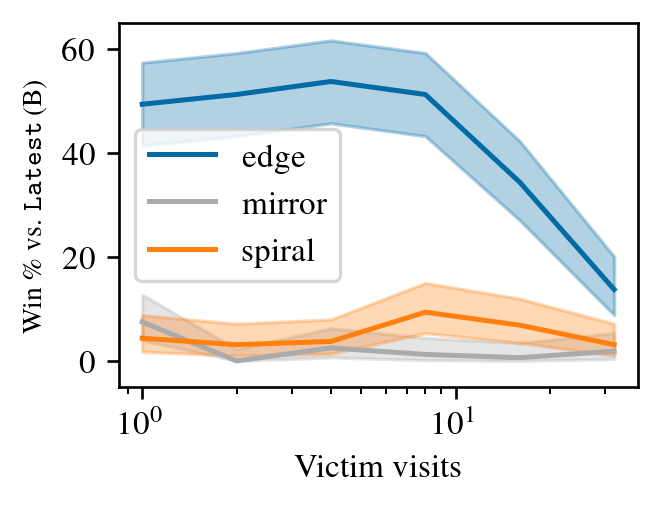

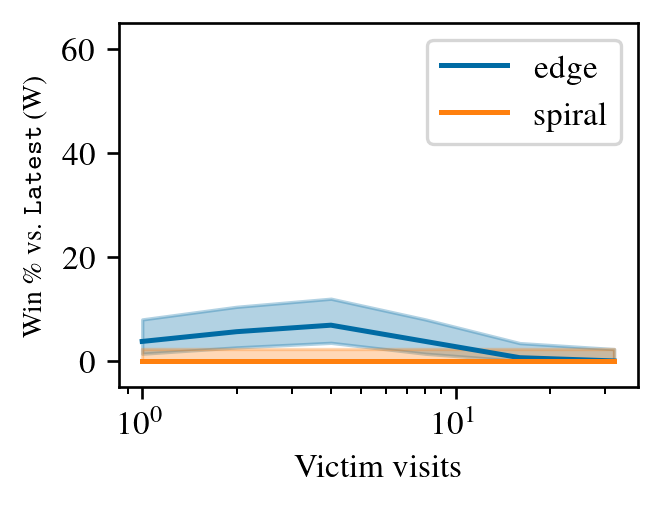

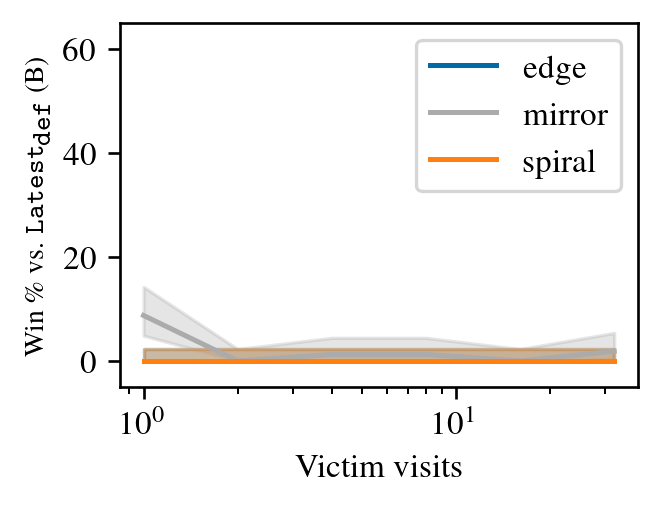

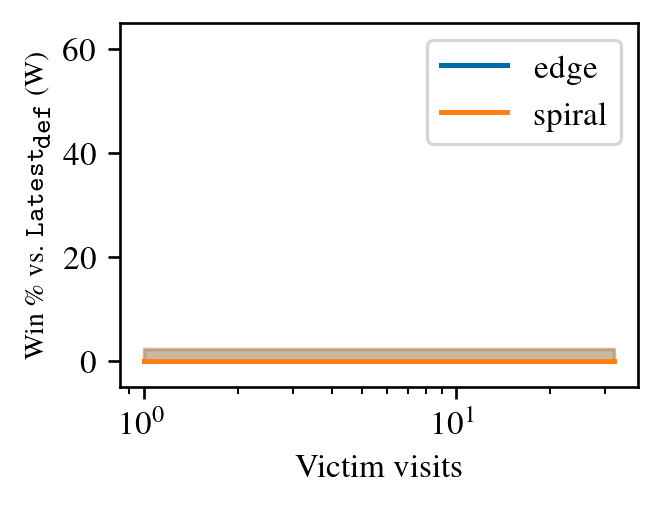

In [5]:
plots_data = generate_plots(df, "adv_win", y_lower=-5, y_upper=65)
for plot_data in plots_data:
    plot_data["fig"].savefig(f"baseline-attack-{plot_data['victim']}-{plot_data['victim_color']}-win-rate.pgf", backend="pgf")

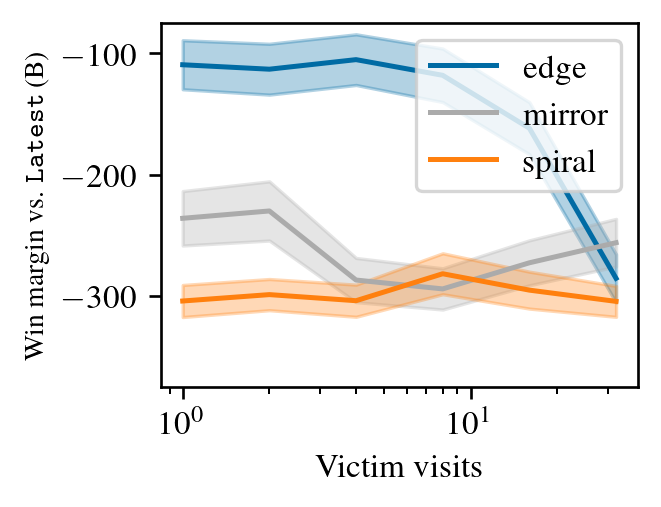

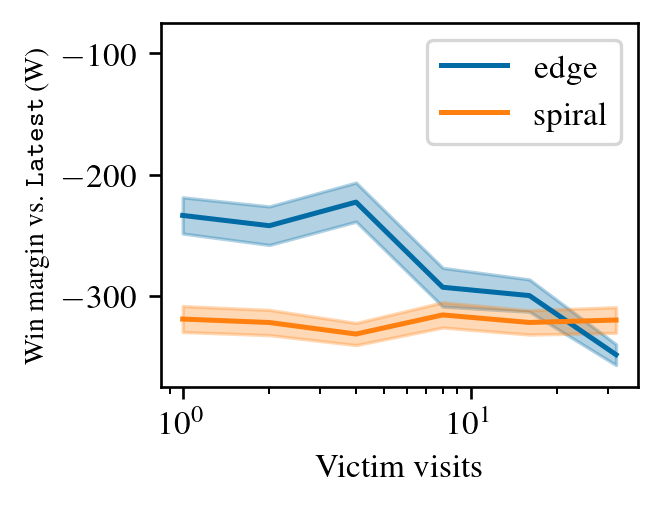

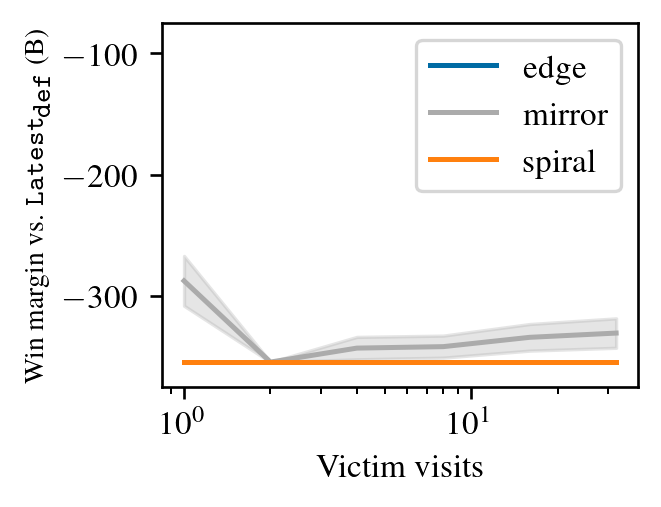

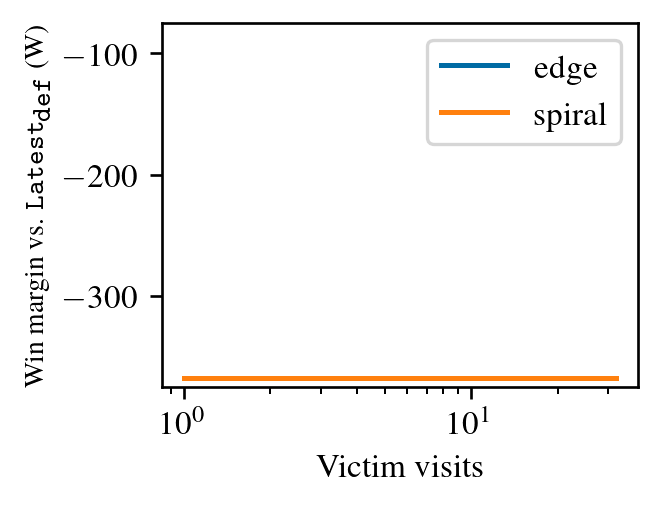

In [6]:
plots_data = generate_plots(df, "adv_minus_victim_score", y_lower=-375, y_upper=-75)
for plot_data in plots_data:
    plot_data["fig"].savefig(f"baseline-attack-{plot_data['victim']}-{plot_data['victim_color']}-win-margin.pgf", backend="pgf")